In [1]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LogNorm
from datetime import timedelta

In [2]:
def lerp(start, end, t):
	r = start[0] + (end[0] - start[0]) * t
	g = start[1] + (end[1] - start[1]) * t
	b = start[2] + (end[2] - start[2]) * t
	a = start[3] + (end[3] - start[3]) * t
	return (r / 255.0, g / 255.0, b / 255.0, a)

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

In [3]:
hex_list = ['#85ff00', '#fff100', '#ffaa04', '#ff0000', '#dc00ff', '#6700d4']#, '#1200db', '#0a014a']
scales = [0, 10, 100, 1000, 10000, 100000]#, 1000000, 10000000]
colors = [(0x85, 0xff, 0x00, 1.0), (0xff, 0xf1, 0x00, 1.0), (0xff, 0xaa, 0x04, 1.0), (0xff, 0x00, 0x00, 1.0), (0xdc, 0x00, 0xff, 1.0), (0x67, 0x00, 0xd4, 1.0), (0x12, 0x00, 0xdb, 1.0)]#, (0x12, 0x00, 0xdb, 1.0), (0x0a, 0x01, 0x4a, 1.0), ]

In [4]:
df = pd.read_csv('exposed_by_type_num_of_vulns.csv')
type_names = list(set(df['type'].unique()) - set(["?"]))

dates = sorted(list(df.date.unique()))

done = 0
output = {}
first_appearance = {}
for _types in type_names:
	c = []
	for d in range(len(dates)):
		if not _types in list(df[(df.date == dates[d])]['type']) or df[(df.date == dates[d]) & (df['type'] == _types)]['vulnerability_count'].iloc[0] == 0:
			c += [(0, 0, 0, 0)]
		else:
			first_appearance[_types] = dates[d]
			v = df[(df.date == dates[d]) & (df['type'] == _types)]['vulnerability_count'].iloc[0]
			idx = -1
			for s in range(len(scales) - 1):
				if scales[s] < v and v <= scales[s+1]:
					idx = s
			if idx == -1:
				c += [lerp(colors[-1], colors[-1], 0.5)]
			else:
				c += [lerp(colors[idx], colors[idx+1], (v - scales[idx])/(scales[idx + 1] - scales[idx]))]
	done += 1
	print(f'{str(done).zfill(len(str(len(type_names))))}/{len(type_names)}: {_types}')
	output[_types] = c


01/16: firewall
02/16: load-balancer
03/16: hypervisor
04/16: nas
05/16: printer
06/16: appliance
07/16: device-management
08/16: hmi-panel
09/16: wireless-access-point
10/16: voip
11/16: application-delivery-controller
12/16: video-system
13/16: router
14/16: conferencing-system
15/16: web-enabled-controller
16/16: plc


In [5]:
from json import dumps
jsonified = dumps(output)
with open('./exposed-type-num-of-vulns.json', 'w') as f:
    f.write(jsonified)
    f.close()

In [6]:
# Sort infection names initial date (color tuple not 0 0 0 0 ) then alphabetical
appearance = {}
for _types in type_names:
    for c in range(len(output[_types])):
        if output[_types][c][0] != 0 or output[_types][c][1] != 0 or output[_types][c][2] != 0 or output[_types][c][3] != 0:
            appearance[_types] = c
            break

appearance_inv = {i: [] for i in range(len(dates))}

for v in sorted(list(appearance.items()), key=lambda x: x[1]):
    appearance_inv[v[1]] += [v[0]]

for i in range(len(dates)):
    if len(appearance_inv[i]) == 0:
        del(appearance_inv[i])
    else:
        appearance_inv[i] = sorted(appearance_inv[i])

type_names_sorted = [x for xs in [v for k, v in appearance_inv.items()] for x in xs][::-1]

In [7]:
# Real max is 21000
norm=LogNorm(vmin=1, vmax=99999)
cmappable = ScalarMappable(norm=norm, cmap=get_continuous_cmap(hex_list=hex_list))

In [8]:
dates = sorted(list(df.date.unique()))
m_dates = mdates.num2date(mdates.datestr2num(dates))
m_dates[-1]

datetime.datetime(2022, 5, 4, 0, 0, tzinfo=datetime.timezone.utc)

01/16: application-delivery-controller
02/16: load-balancer
03/16: conferencing-system
04/16: printer
05/16: voip
06/16: hmi-panel
07/16: web-enabled-controller
08/16: plc
09/16: device-management
10/16: wireless-access-point
11/16: video-system
12/16: router
13/16: nas
14/16: hypervisor
15/16: firewall


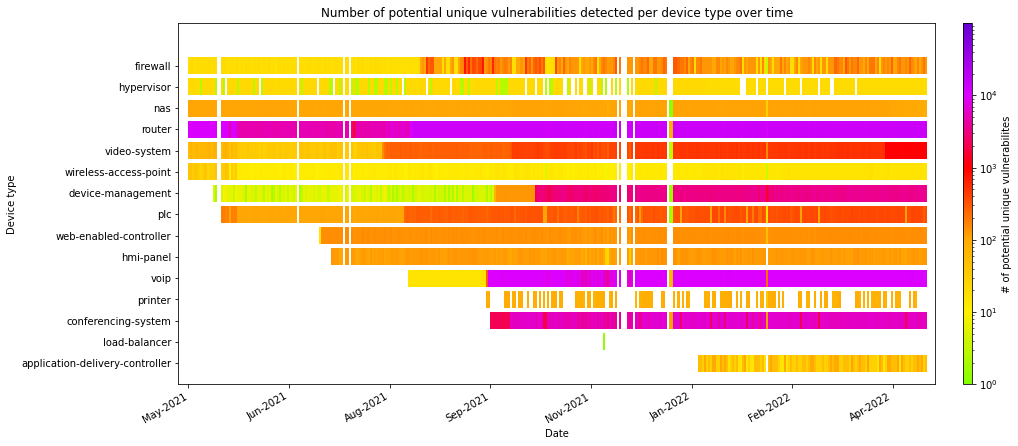

In [9]:

plt.rcParams["figure.figsize"] = (16.54, 7.38)

fig, ax = plt.subplots(figsize=(16.54, 7.38))
y = 0
done = 0

for _types in type_names_sorted:
	for c in range(len(output[_types])):
		ax.barh(y, 1, left= m_dates[c], height=0.8, align='center', color=output[_types][c])
	y += 1
	done += 1
	print(f'{str(done).zfill(len(str(len(type_names))))}/{len(type_names)}: {_types}')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y')) 
ax.axis('tight')
ax.set_xlim([m_dates[0] - timedelta(days=5), m_dates[-1] + timedelta(days=5)])
ax.set_ylim([-1, len(type_names_sorted) + 1])
ax.set_yticks(np.arange(len(type_names_sorted)))
ax.set_yticklabels(type_names_sorted)


ax.set_xlabel('Date')
ax.set_ylabel('Device type')

fig.autofmt_xdate()

cb =fig.colorbar(cmappable, aspect=40, pad=0.03)
cb.ax.set_ylabel('# of potential unique vulnerabilites')

ax.set_title("Number of potential unique vulnerabilities detected per device type over time")

plt.savefig('../images/exposed-bytype-num-vulns-better.png', facecolor='white', transparent=False, bbox_inches='tight', pad_inches=.2, dpi=300)
plt.show()